# Bunq Challenge

We want to maximize the Return of investment from our ads. I understand this problem statement as: Bunq wants to get the maximal number of customer by spending the minimum ammount of money. Which means that we want to understand how the features of an advertisement (age, gender and interests) can predict ammount spent and number of approved conversions. 

In this notebook I walk you through what I would have done to reach this maximization goal. There are othe approaches that are possible and would work well. I found simpler to reduce it to a regression problem and use standard regression techniques. 

First I try to get some intuition about the data by analizing and visualizing it. I create a new label based on the given ones as I think it captures best what we are trying to maximize. Then I build and optimize different models to perform the regression task. Here I show the results that I get for using Linear Regression (as baseline), Random Forest and a Neuralnet (Multilayer Perceptron). 

Having a model predictive model, I can now prioratize ads based on their features. I show one way of doing that and how I would implement it in production. Finally I use some visualisation techiniques to suggest how it would be possible to get insights about our advertisement campaigns.

In [1]:
#base libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
import warnings
import time

#Jupyter visualization
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999
warnings.filterwarnings("ignore")

#advanced libaries
import pickle
import category_encoders as ce
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, Imputer
import lime
from lime import lime_tabular
import seaborn as sns

#ML libaries
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

#install tqdm: https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482

First thing to do is to load the data.

I noticed that the last 400 rows of the dataset were corrupted. "campaign_id" and "fb_campaign_id" had age and gender in them and all other values were shifited to the right. Because the data set is small I just corrected it using excel. Due to that, I just ignore the "campaign_id" and "fb_campaign_id" in the following analysis. 

In [2]:
df_bq = pd.read_csv('data_clean.csv', 
                    header=0, 
                    sep=',', 
                    index_col=0, 
                    parse_dates=True, 
                    encoding='ISO-8859-1', 
                    tupleize_cols=None, 
                    infer_datetime_format=False,
                    error_bad_lines = False)

#Some statistics about the data
df_bq.describe(include = "all")

,reporting_start,reporting_end,campaign_id,fb_campaign_id,age,gender,interest1,interest2,interest3,impressions,clicks,spent,total_conversion,approved_conversion
count,1143,1143,761.000000,761.000000,1143,1143,1143.000000,1143.000000,1143.000000,1.143000e+03,1143.000000,1143.000000,1143.000000,1143.000000
unique,14,14,NaN,NaN,4,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,18/08/2017,18/08/2017,NaN,NaN,30-34,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,109,109,NaN,NaN,426,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,1011.855453,123915.060447,NaN,NaN,32.766404,36.245844,36.222222,1.867321e+05,33.390201,51.360656,2.855643,0.944007
std,NaN,NaN,113.981878,14933.704161,NaN,NaN,26.952131,26.937853,26.924679,3.127622e+05,56.892438,86.908418,4.483593,1.737708
min,NaN,NaN,916.000000,103916.000000,NaN,NaN,2.000000,3.000000,3.000000,8.700000e+01,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,936.000000,110982.000000,NaN,NaN,16.000000,20.000000,20.000000,6.503500e+03,1.000000,1.480000,1.000000,0.000000
50%,NaN,NaN,936.000000,116341.000000,NaN,NaN,25.000000,28.000000,28.000000,5.150900e+04,8.000000,12.370000,1.000000,1.000000
75%,NaN,NaN,1178.000000,144549.000000,NaN,NaN,31.000000,35.000000,35.000000,2.217690e+05,37.500000,60.025000,3.000000,1.000000


Because we are interested to maximise the number of approved_conversion and minimize the total spent, I take their quotient and add it to a new column called "conv/spent".

If we are also interested in only showing the adds for customers that are likelly to sign up, then we can incorporate that as well. That is what I do in the column "conf/(spent\*imp)".



In [3]:
#Make new, maybe interesting, targets

# +1 is added to the denominator of both as to avoid division by zero and cap the max value of the quotient. 
df_bq["conv/spent"] = (df_bq["approved_conversion"])/(df_bq["spent"]+1)
df_bq["conv/(spent*imp)"] = (df_bq["approved_conversion"])/(df_bq["spent"]*df_bq["impressions"]+1)

df_bq[["conv/spent", "conv/(spent*imp)"]].describe()

,conv/spent,conv/(spent*imp)
count,1143.000000,1.143000e+03
mean,0.111883,6.650216e-02
std,0.275887,2.662331e-01
min,0.000000,0.000000e+00
25%,0.000000,0.000000e+00
50%,0.004936,5.208733e-09
75%,0.045935,3.290316e-07
max,2.000000,2.000000e+00


Plot some relationships to get some intuition behind the data in order to get some intuition of it.

The bar plots show the approved_convertion/spent vs interests for each campaing. The higher the bar the more relevant that interest is (note that even though this may show a correlation, it is very much possible that there is little or no casuality). The variances are quite large, which points that the data may not be sufficient to take meaninful conclusions from.

Campain 1178 was only targted to males, that may bias the data because we cannot know how the campaign 1178 would perform when showed to women. That is one extra reason to ignore the *campaign_ids* as a feature. The column is imcomplet and the data is skewed. 

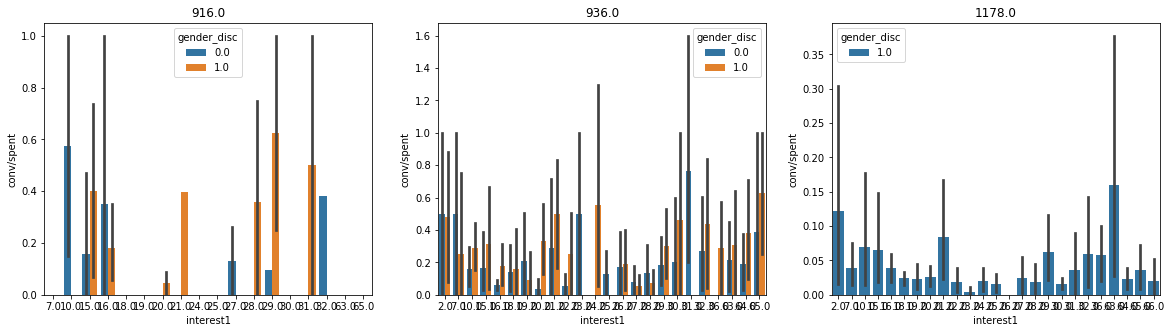

In [4]:
#Interest 1:

keys = df_bq['campaign_id'].unique()[:-1]

#maps gender to 1 and 0
df_bq['gender_disc'] = df_bq['gender'].apply(lambda x: 1 if x is 'M' else 0)

plt.figure(figsize = (20,5))
for i, key in enumerate(keys):
    plt.subplot(1, len(keys), i+1)
    plt.title(key)
    df_q = df_bq.where(df_bq['campaign_id'] == key).dropna()
    sns.barplot(x=df_q['interest1'], y=df_q['conv/spent'], hue=df_q['gender_disc'])

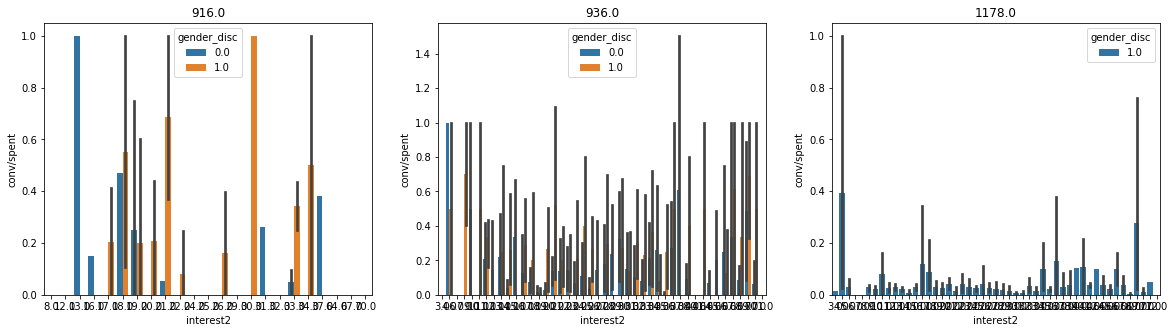

In [5]:
#interest 2
plt.figure(figsize = (20,5))
for i, key in enumerate(keys):
    plt.subplot(1, len(keys), i+1)
    plt.title(key)
    df_q = df_bq.where(df_bq['campaign_id'] == key).dropna()
    sns.barplot(x=df_q['interest2'], y=df_q['conv/spent'], hue=df_q['gender_disc'])

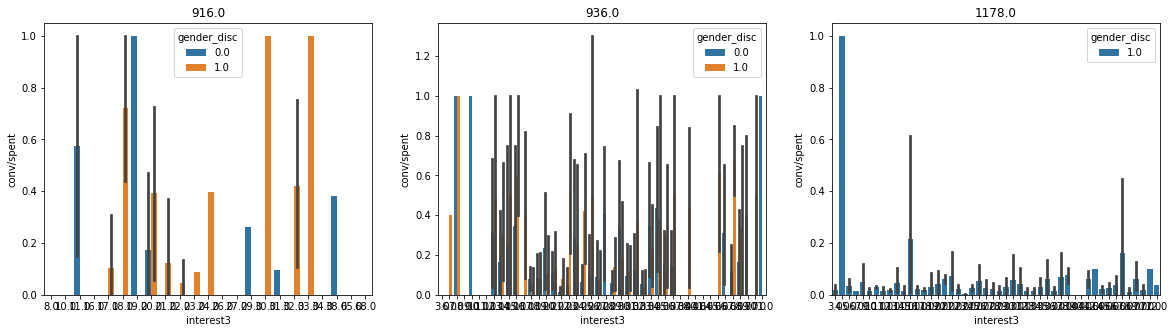

In [6]:
#interest 3
plt.figure(figsize = (20,5))
for i, key in enumerate(keys):
    plt.subplot(1, len(keys), i+1)
    plt.title(key)
    df_q = df_bq.where(df_bq['campaign_id'] == key).dropna()
    sns.barplot(x=df_q['interest3'], y=df_q['conv/spent'], hue=df_q['gender_disc'])

We want to build a model that learns from the data. Given a set of features that describe an advertisement, we want to predict the *approved_conversion/spent*. That is a regression problem.

To describe an advertisement we use the following features: *age, gender, interest1, interest2, interest3*. 

Age is taken as the mean of the interval. A different approach could be taken, we could take either extreme of the interval or a random number between them. The different implemetations are not expected to have too much of an impact on the performace of the model for the given data. 

Gender is encoded binarily as 1 for Males and 0 for Females. 1 and -1 could be used instead if we would like to encode genders as having oposite meanings, Males being the oposite of Females. Another approach is to one-hot encode the gender. However, becase there are only two possibilities, one-hot encoding is not expected to perform any different than binary labels.

It was not clear what interest 1,2 and 3 are. There are mostly two ways of interpreting them:
1. They are categories of interest and the number corresponds to how much the person is interested on that category. Taking facebook as context, the number could be the amount of likes a person gave to posts related to interest 1, 2 and 3.  if interest 1 is cooking, then the number 16 is the average amount of likes the targeted group gave to posts related to cooking. This means that the data is sequential (just like age) and should be taken as such. As an example: 

2. The interests are groups of categories and the numbers represent an specific category. For instance, interest 1 is cooking, then the number 16 means the targeted group are interested in vegan recepies, and 17 means interest in spicy salces. This approach means that there is no sequence in the data (interest 16 is not closer to interest 30 than interest 60). To deal with this sort of data we would have to first one-hot encode it (very sparce, but easy to interpret) or hash it (dense, but hard to interpret).

For sake of simplicity, and based on how facebook is built around the *like* metric, we assume that interest 1,2 and 3 are sequential (case 1). 

I am specifically ignoring the reporting dates as features. The main reason for that is that, if we want to predict how well future ads will perform, past dates are irrelevant. Instead of including the dates we could use them to generate a periodic signal in order to try to encode information about the progress of the week or months. The main reason it is not included here it is because we have less than 2 weeks worth of data. That is not is not enough to encode anything meaningful about events of a week, even worse, our model may be biased towards an specific event that happened in one of the weeks but it is not expected to repeat anytime soon, such as holidays. 

The other fields of our dataset are never known before the add goes live, so we cannot use them as features. However, we can use them as labels and see if the models respond better to a particular one.


In [7]:
#pre-process the data

#select features
feat_df = df_bq[["age", "gender", "interest1", "interest2", "interest3"]]

#binary encoding of gender
feat_df["gender"] = feat_df["gender"].apply(lambda x: 1 if x == "M" else 0)

#conversion of age from categories to numbers.
feat_df["age"] = feat_df["age"].apply(lambda x: int(x[-2:])/2 + int(x[-5:-3])/2)

# conv/spent are from 0-2, no need to normalize them.
label_df = df_bq["conv/spent"]

I then proceed to split our data into train and test set. 80% of the data is available for the train set. Because the dataset is quite small we take the risk that the test set and the train set do not share the same underlying distribution - in a extreme case, all the test set is populated with male gender features. It is good practice to have some indicators to flag when that is the case. Two metrics often used are the mean and the standard deviation, to ease our mindes we see that there aren't far appart.

After spliting the data it is recomended to normalize it (that is mostly done because neural networks have a hard time learning from features with very different scales). It is important to normalize the data only after the split is done. That is because our model should not see any of the test data while learning, if the normalization is done before the split then we may bias the model.



In [8]:
#split data into test and train (use random split or split on period)
x_train, x_test, y_train, y_test = train_test_split(feat_df, label_df, test_size=0.2, random_state=42)


#normalize data based on the test set
normalizer = MinMaxScaler()
normalizer.fit(x_train)

x_train = pd.DataFrame(normalizer.transform(x_train),
                       columns = x_train.keys(),
                       index = x_train.index)

#test test is normalized based on test set. 
x_test = pd.DataFrame(normalizer.transform(x_test),
                      columns = x_test.keys(),
                      index = x_test.index)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [9]:
x_train.describe(include = "all")

,age,gender,interest1,interest2,interest3
count,914.000000,914.000000,914.000000,914.000000,914.000000
mean,0.424508,0.514223,0.276424,0.293130,0.285334
std,0.393079,0.500071,0.244207,0.239659,0.233962
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.125000,0.149123,0.145299
50%,0.333333,1.000000,0.200893,0.219298,0.213675
75%,0.666667,1.000000,0.258929,0.280702,0.273504
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
x_test.describe(include = "all")

,age,gender,interest1,interest2,interest3
count,229.000000,229.000000,229.000000,229.000000,229.000000
mean,0.409025,0.532751,0.267818,0.285643,0.278431
std,0.396250,0.500019,0.226244,0.222775,0.214528
min,0.000000,0.000000,0.000000,0.026316,0.034188
25%,0.000000,0.000000,0.125000,0.157895,0.145299
50%,0.333333,1.000000,0.214286,0.228070,0.222222
75%,0.666667,1.000000,0.258929,0.280702,0.273504
max,1.000000,1.000000,1.000000,1.008772,0.991453


Finally, the model!

Because that is a regression problem, the baseline taken is the Linear Regression (which is most widelly used and simple to use in tools like excel). If we want to get insights from out data, Random Forest are very simple to interpret, that is why we include it here. We included a Multi Layer Perceptron because there is a big hipe around them.

I also played around with other models such as Gaussian Processes, K-Means, SMV for regression and Decision trees. But those did not perform well and we preffered not to include them here.

In [11]:
#models we will use to predict conv/spent
model = {"LR": LinearRegression(), # baseline
         "MLP": MLPRegressor(random_state = 42), # The fashonable choice that won't perfrom well
         "RF": RandomForestRegressor(random_state = 42), # the easiest to interprate
}

#parameters of the models we are interested in optimizing.
m_params = {
    "LR": {"fit_intercept": [True, False]},
    "MLP": {"hidden_layer_sizes": [(100,), (100, 200), (200, 200), (100, 100, 100, 100)],
            "activation": ["relu", "tanh", "logistic"],
            "max_iter": [100, 200, 1000]},  
    "RF": {"n_estimators": [5, 10, 20, 100],
           "max_depth": [10, 20, None],
           "max_features": ["sqrt", "log2", None]},
}


The models are optimized using Random Search. This seach basically samples the paramers and keeps a recod of the best set of parameter yet. It is less computationally intensive than gridsearch and has been shown to perform in the same level as the later.

In [12]:
search_inter = 20 #number of iterations for the random search.

#Optimizes all models.
for m in model:
    random_search = RandomizedSearchCV(model[m], 
                                       param_distributions = m_params[m], 
                                       n_iter = search_inter) #implement that instead of fit.
    
    random_search.fit(x_train, y_train)
    model[m] = random_search.best_estimator_
    print(m, model[m])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:271: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


LR LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
MLP MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
RF RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


Now we can compare the models based on our test set. The test set is the data that the model has never seen, if the model is capable of generalizing, it should perform well on the test set. 

We have two metrics, Score and Mean Squared Error (SME). For Score, the higher the better, for SME the closest to zero the better. The metrics agree on the performance of the models. MLP is the best one, however Linear Regression is not too far behind, and it has the nice properties of being easy to implement and deterministic (MLP could perform worse in another run).

In [13]:
#final test:
for m in model:
    print("Model type:", m)
    print("Model parameters:", model[m])
    print("Score:", model[m].score(x_test, y_test))
    y_pred = model[m].predict(x_test)
    MSE = sum((y_pred - y_test)**2)/len(y_test)
    print(f"SME: {MSE}")
    print("______________________________________________")

Model type: LR
Model parameters: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Score: 0.031845143398341214
SME: 0.06005330891721477
______________________________________________
Model type: MLP
Model parameters: MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=42, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)
Score: 0.03670622200428875
SME: 0.05975178292351319
______________________________________________
Model type: RF
Model parameters: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='log2', max_leaf_nodes=None,
           min_impurity_decrease=0.0, 

Now that we have the model, we can use it to prioritise ads. Let's supose that we have 100 ads and we want to pick the best best one to advertise, the decision can be done by chosing the ad that shows the highest return.

It is worth noting that here I am not explicitly giving the the credit assigment for each ad. That is because, for the specified problem, the best credit assigment is to spend all the budged in the best ad. In portifolio management this choice is made based on the portifolio assigment that would optimize last last month (weeks or years, depending of what is being traded). However, the data we have avalable we cannot track how well one specif advertisement did overtime. 

### How would to bring it to production?
Inez informed me that Bunq uses AWS, which offers great cloud infrastructure to train models that are much better than the ones I presented here. I have not worked with AWS so far, so I can really not tell the specific steps on how to do it. If I was the one responsible for it, I would start by using the tips described here: https://www.quora.com/How-do-you-take-a-machine-learning-model-to-production to implement the cycle described in the image. I imagine that different database structures and APIs will require different approaches, but the overall idea is the same.


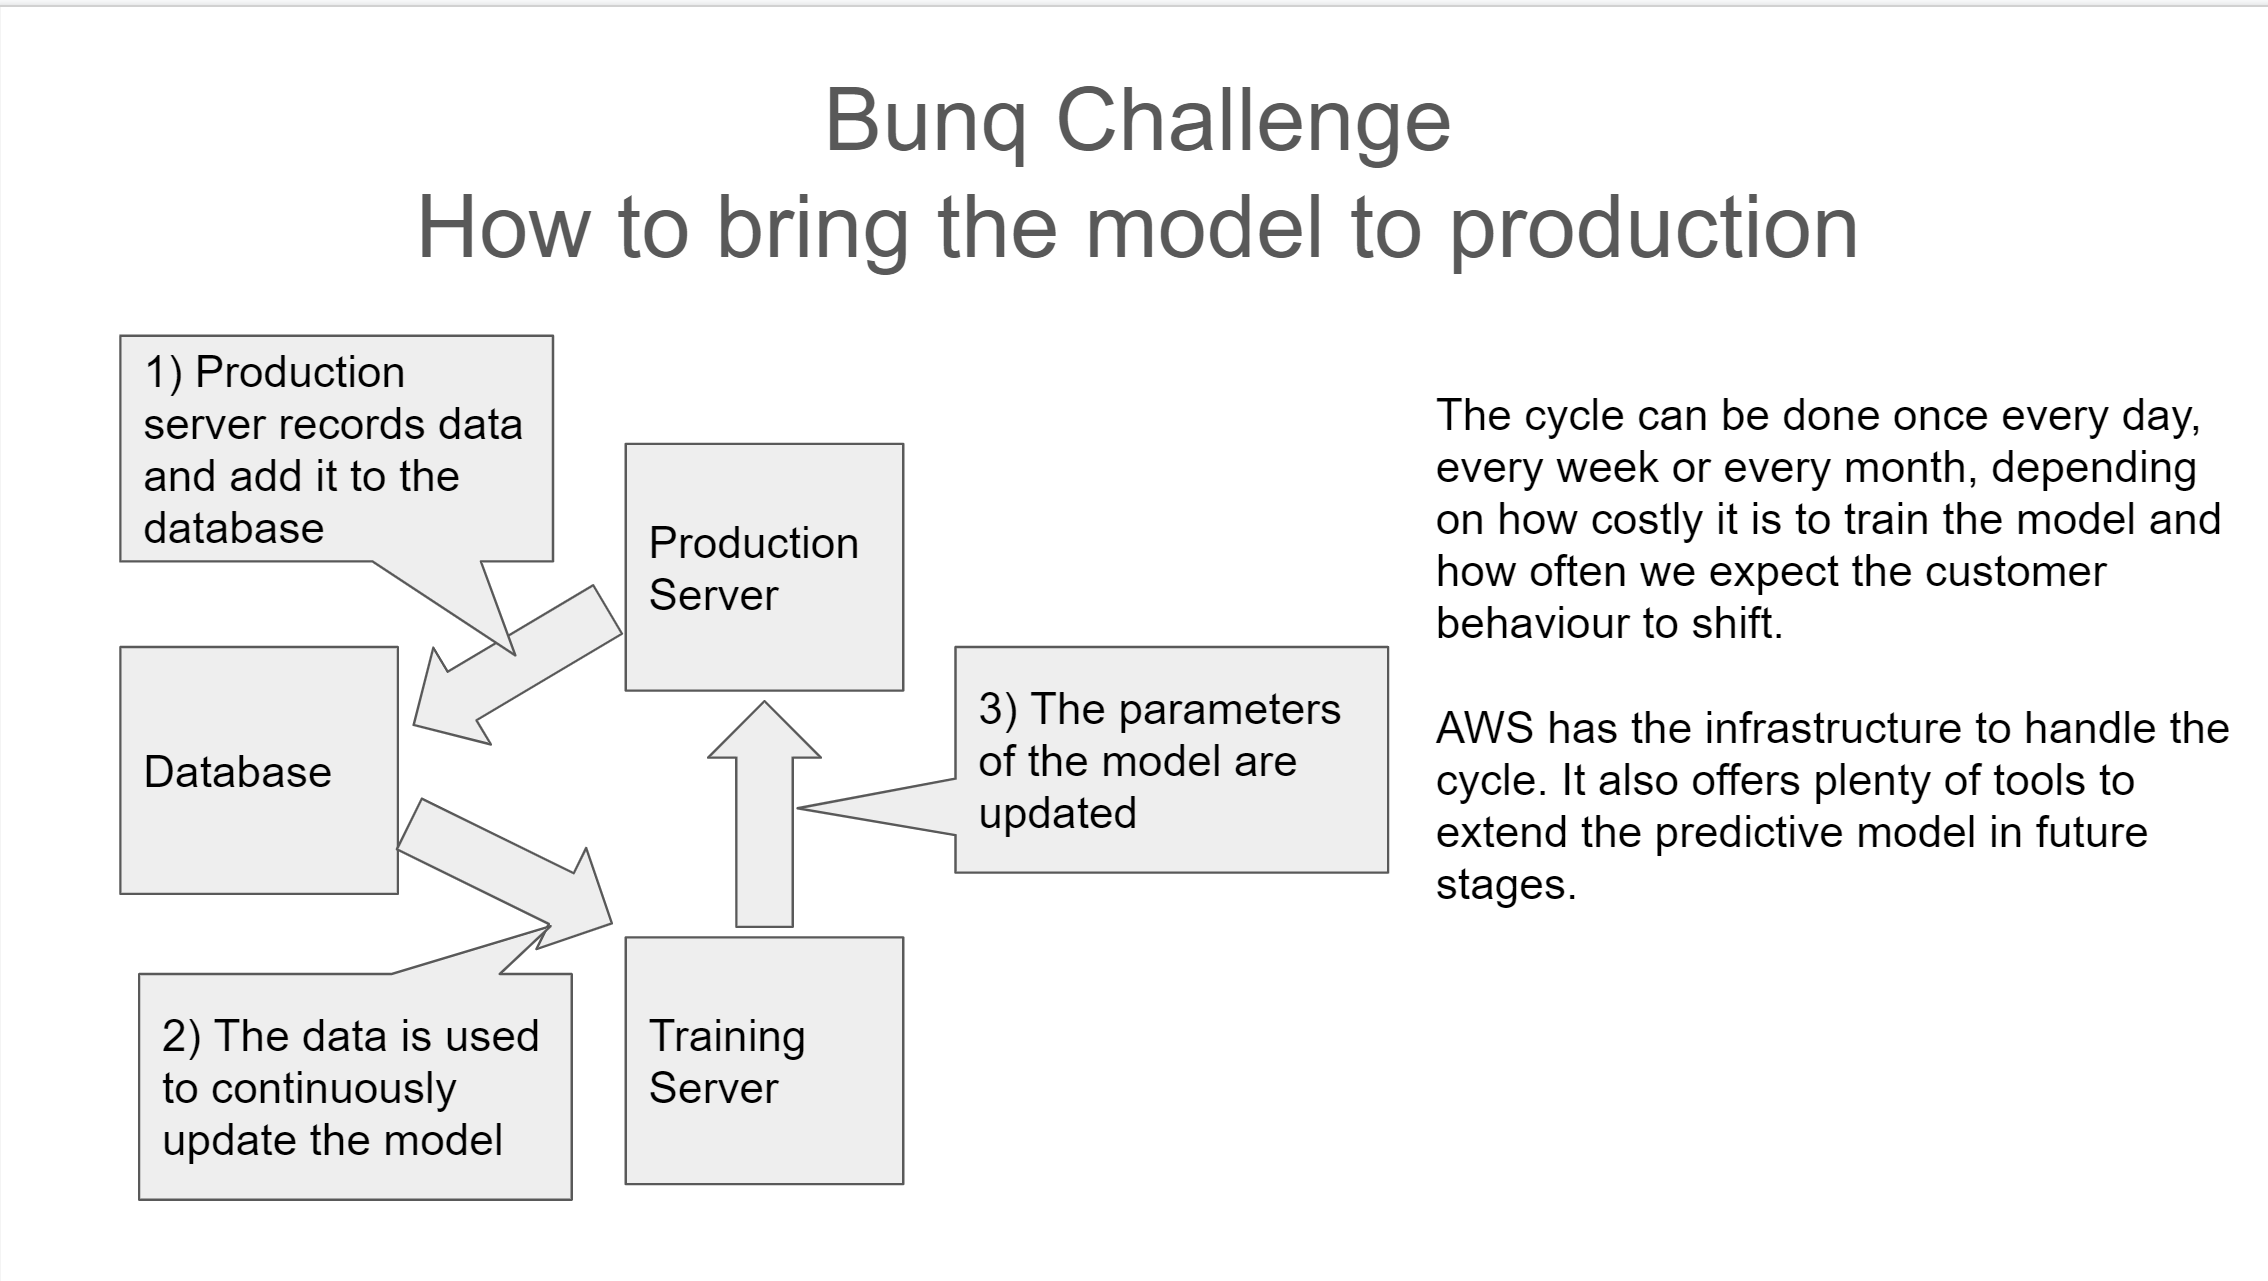


In [14]:
#Adds we are not sure to advertise
x_ad = x_test[0:100]

#The model predicts how well each ad will perform.
y_ad = model["MLP"].predict(x_ad)

#List of indexes ordered from worst to best ad
sorted_ads = np.argsort(y_ad)

#Display conclusions
print(f"The index of the best 5 ads are: {sorted_ads[-6:-1]}")
print(f"That is the expected aproved_conversions/spent for each on the them: {y_ad[sorted_ads[-6:-1]]}")
print(f"The average aproved_conversions/spent so far is: {y_train.mean()}")


The index of the best 5 ads are: [88 98 32 47 99]
That is the expected aproved_conversions/spent for each on the them: [0.18310431 0.18505036 0.18778069 0.18942383 0.19029074]
The average aproved_conversions/spent so far is: 0.11164707787786242


If we are interested in having insights about how the features impact our results, the best place to look is the feature importance of the random forests. (It is also possible to do that for MLP, but reading the results is much less intuitive due to it's non-linearity).

It is possible to see that interest 2 and interest 3 are the ones that contribute the most and age and gender contribute the least. Such information can be used by marketing when developing new campaings.

1. feature[3]: 0.3286253007727143, column: interest2
2. feature[4]: 0.2947297039572407, column: interest3
3. feature[2]: 0.19815210426709814, column: interest1
4. feature[0]: 0.09607571106975316, column: age
5. feature[1]: 0.08241717993319352, column: gender


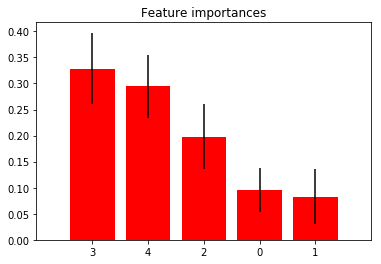

In [15]:
#load feature importances
f_importance = model["RF"].feature_importances_

#calculates the standard deviation
std = np.std([tree.feature_importances_ for tree in model["RF"].estimators_],
             axis=0)

#display all featues, afterall, we only have 5 of them.
display_top = 5 

indices = np.argsort(f_importance)[::-1]
x_train.iloc[:,indices[0:display_top]].describe()

for f in range(display_top): 
    print(f"{f + 1}. feature[{indices[f]}]: {f_importance[indices[f]]}, column: {x_train.iloc[:,indices[f]].name}")
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(display_top),
        f_importance[indices[0:display_top]],
        color="r", 
        yerr=std[indices[0:display_top]], 
        align="center")
plt.xticks(range(display_top), indices)
plt.xlim([-1, display_top])
plt.show()

That is all!